In [1]:
%%capture
!pip install tensorflow-datasets==4.8 --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install pydot --quiet
!pip install transformers==4.17 --quiet
!pip install -U scikit-learn

In [2]:
#Tensorflow libiries
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

#Transformers - BERT from huggingface
from transformers import BertTokenizer, TFBertModel
from transformers import logging
logging.set_verbosity_error()
from transformers import AutoConfig
from tensorflow.keras.callbacks import EarlyStopping

#NLP libiries
import sklearn as sk
from sklearn.metrics import classification_report
import os
import nltk
from nltk.data import find

#data process
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
import pandas as pd
import math
from bs4 import BeautifulSoup
import os
import json


In [3]:
#loading the pre-trained tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

In [4]:
#load the dataset
full_dataset=pd.read_csv('full_dataset(Revised).csv')

test_dataset=pd.read_csv('full_test_data(Revised).csv')

In [5]:
#process the df[date]'s format to date time
full_dataset['date'] = pd.to_datetime(full_dataset['date'])
test_dataset['date'] = pd.to_datetime(test_dataset['date'])

#filter the 2016 dataset for training and taking out the 2016 from the test_dataset
train_df = full_dataset[full_dataset['date'].dt.year == 2016]
test_df = test_dataset[test_dataset['date'].dt.year != 2016]

# Adjust pandas display settings to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full content of each column
pd.set_option('display.width', None)  # Auto-detect width of the display




In [6]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5029 entries, 0 to 5028
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   title             5029 non-null   object        
 1   date              5029 non-null   datetime64[ns]
 2   content_original  5029 non-null   object        
 3   bias              5029 non-null   int64         
 4   bias_text         5029 non-null   object        
 5   source            5029 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 235.9+ KB


In [7]:
train_df.head(1)

,title,date,content_original,bias,bias_text,source
13,"rnc chief threatens john kasich, republican won’t support donald trump",2016-09-18,"republican national committee chairman reince priebus sunday threatened ohio gov. john kasich republican refuse support presidential nominee donald trump, saying party may take step ensure it’s easy them” seek white house again. speaking cbs’ face nation,” mr. priebus said every republican ran 2016 need get behind mr. trump. those haven’t — including mr. kasich, former florida gov. jeb bush, texas sen. ted cruz — could see diminished support party moving forward. people agreed support nominee, took part process, used tool rnc. agreed support nominee. took part process. we’re private party, we’re public entity. people need get board,” mr. priebus said. and they’re thinking they’re going run someday, think we’re going evaluate process, nomination process, don’t think it’s going easy them,” said. mr. kasich said it’s unlikely” he’ll vote mr. trump … much water bridge,” ohio governor said interview cnn aired friday. see also: 48% democratic voter say bernie sander replace hillary drop race mr. bush expressed similar sentiments, mr. cruz famously withheld endorsement mr. trump republican national convention instead told republican vote conscience” november. mr. priebus denied threatening mr. kasich, mr. cruz anyone else, yet clearly suggested party would put roadblock front electoral hope anyone hasn’t offered fullthroated endorsement mr. trump. people party talking we’re going … it’s threat. it’s question,” rnc chairman said. private party people come around four eight years?” mr. kasich, former 2016 gop presidential candidate himself, said it’s still important get vote republican like sen. rob portman, running reelection ohio. we want get people vote. want reelect senator portman, want reelect people ticket,” mr. kasich said. i’m voting hillary [clinton].” i’ll let everybody know … think action spoken loudly. louder even words,” said. mr. kasich cleveland republican national convention july, attend convention itself. asked libertarian nominee gary johnson, mr. kasich said: haven’t even gone yet. it’s long way [until] election day.” sign daily newsletter copyright © 2019 washington times, llc. click reprint permission.",2,right,Washington Times


In [ ]:
print(f"basic train_df info: ",train_df.shape)

basic train_df info:  (2893, 6)


In [ ]:
test_df.head(1)

,title,date,content_original,bias,bias_text,source
1,opinion: john brennan: president trump’s claim collusion hogwash,2018-08-16,"when alexander bortnikov, head russia’s internal security service, told early august 2016 phone call russia wasn’t interfering presidential election, knew lying. previous several year grown weary mr. bortnikov’s denial russia’s perfidy — mistreatment american diplomat citizen moscow, repeated failure adhere ceasefire agreement syria paramilitary intervention eastern ukraine, name issues. when warned mr. bortnikov russian interference election intolerable would roil united statesrussia relation many years, denied russian involvement election, america elsewhere, feigned sincerity heard many time before. president vladimir putin russia reiterated denial numerous time past two years, often donald trump’s seeming approval. russian denial are, word, hogwash. before, infamous meddling last presidential election, russia practiced art shaping political event abroad wellhoned active measure program, employ array technical capabilities, information operation oldfashioned human intelligence spycraft. electoral politics western democracy present especially inviting target, variety politicians, political parties, medium outlets, think tank influencers readily manipulated, wittingly unwittingly, even bought outright russian intelligence operatives. freedom liberty liberal western democracy cherish autocracy fear exploited russian intelligence service collect sensitive information also distribute propaganda disinformation, increasingly via growing number social medium platforms. having worked closely f.b.i. many year counterintelligence investigations, well aware russia’s ability work surreptitiously within united states, cultivating relationship individual wield actual potential power. like mr. bortnikov, russian operative agent well trained art deception. troll political, business cultural water search gullible unprincipled individual become pliant hand russian puppet masters. often, puppet found.",0,left,New York Times - News


In [ ]:
print(f"basic test_df info: ",test_df.shape)

basic test_df info:  (4407, 6)


In [8]:
# extract the train and test text from both dataframes
train_text = train_df['content_original']
train_text_labels = train_df['bias']

test_text = test_df['content_original']
test_text_labels = test_df['bias']


print(f"size of training dataset: ",len(train_text))
print()
print(f"size of testing dataset: ",len(test_text))
print()
print(f"Left with Label 0 ")
print(f"Center with Label 1 ")
print(f"Right with Label 2 ")

size of training dataset:  2893

size of testing dataset:  4407

Left with Label 0 
Center with Label 1 
Right with Label 2 


In [9]:
MAX_SEQUENCE_LENGTH = 512

In [10]:
# tokenize the dataset, truncate at `max_length`,

#tokenizing the train text
x_train = bert_tokenizer(train_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_train = train_text_labels

# #tokenizing the validate text
# x_validate = bert_tokenizer(validate_text.tolist(),
#               max_length=MAX_SEQUENCE_LENGTH,
#               truncation=True,
#               padding='max_length',
#               return_tensors='tf')
# y_validate = validate_text_labels


#tokenizing the test text
x_test = bert_tokenizer(test_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_test = test_text_labels

In [11]:
#BERT base uncased model configurations
config = AutoConfig.from_pretrained('bert-base-uncased')

config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#BERT Uncase Model Fine-Tuning with One LSTM Layer

In [12]:
def create_bert_classification_model(bert_model,
                                     num_train_layers=0,
                                     num_classes = 3,
                                     hidden_size = 768,
                                     dropout=0.1,
                                     attention_probs_dropout_prob = 0.1,
                                     hidden_dropout_prob=0.1,
                                    #  lstm_units=90,
                                     learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    #pooler_token = bert_out[1]
    cls_token = bert_out[0][:, 0, :]

    hidden_1 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_1')(cls_token)
    hidden_1 = tf.keras.layers.Dropout(dropout)(hidden_1)


    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden_1)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [13]:
#let's get a fresh instance of the bert_model -- good practice
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_classification_model = create_bert_classification_model(bert_model, num_train_layers=12)

In [14]:
#confirm all layers are frozen
bert_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                      

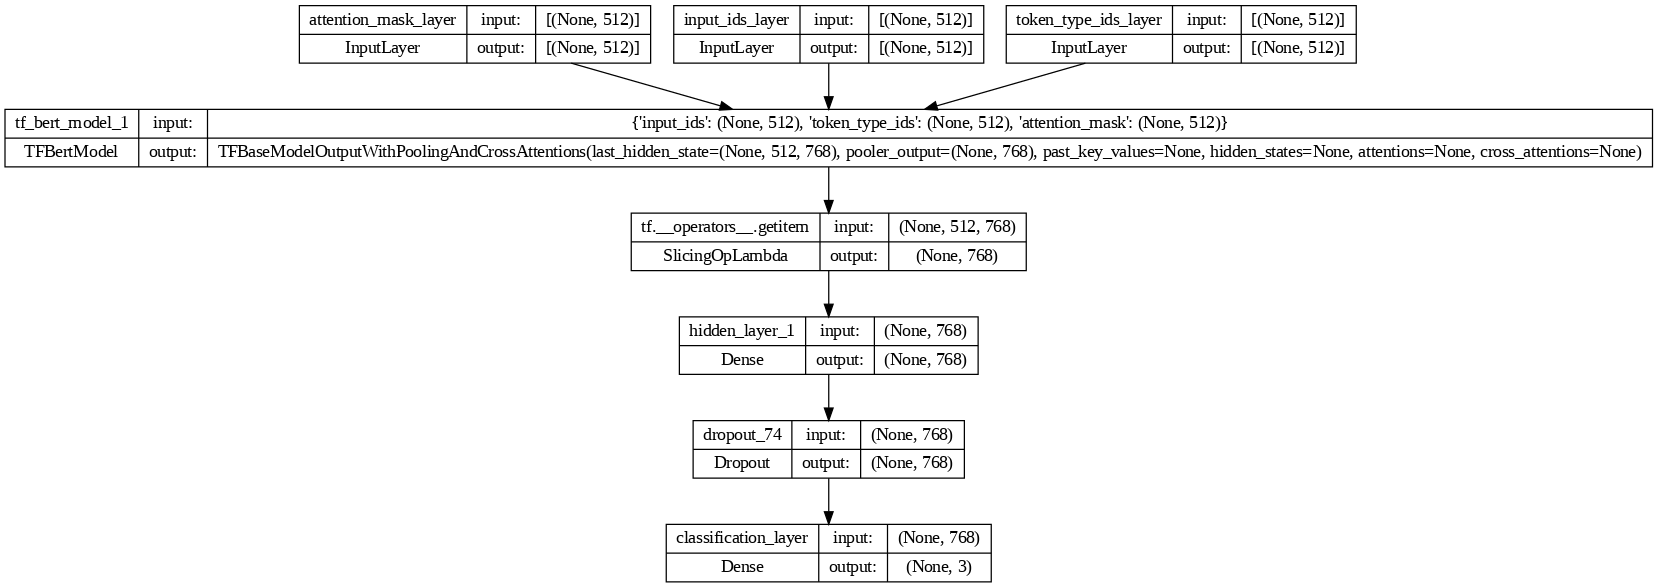

In [15]:
keras.utils.plot_model(bert_classification_model, show_shapes=True, dpi=90)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
# Early stopping callback to avoid overfitting issue
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    mode='max',
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [18]:
bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),
    batch_size=16,
    epochs=4,
    callbacks=[early_stopping]
)

Epoch 1/4
181/181 [==============================] - 322s 2s/step - loss: 1.0497 - accuracy: 0.4507 - val_loss: 0.9612 - val_accuracy: 0.5051
Epoch 2/4
181/181 [==============================] - 306s 2s/step - loss: 0.8790 - accuracy: 0.5804 - val_loss: 0.8530 - val_accuracy: 0.5825
Epoch 3/4
181/181 [==============================] - 306s 2s/step - loss: 0.5618 - accuracy: 0.7601 - val_loss: 0.6810 - val_accuracy: 0.7420
Epoch 4/4
181/181 [==============================] - 306s 2s/step - loss: 0.3867 - accuracy: 0.8500 - val_loss: 0.5994 - val_accuracy: 0.7801


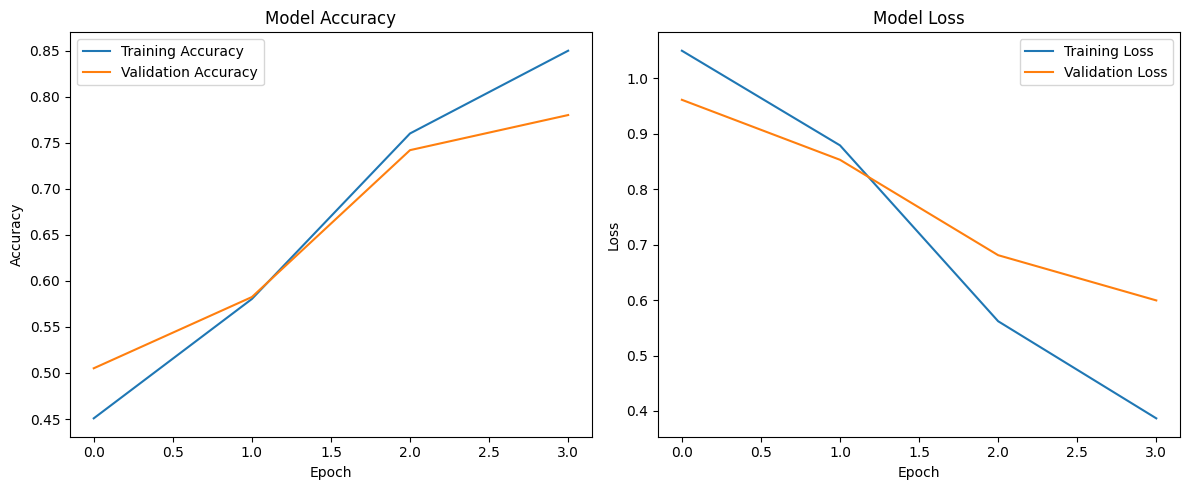

In [19]:
history = bert_classification_model_history.history

# Plotting accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1,2,2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
predictions_model= bert_classification_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
predictions_model = tf.argmax(predictions_model, axis=-1)
predictions_model

138/138 [==============================] - 103s 723ms/step


<tf.Tensor: shape=(4407,), dtype=int64, numpy=array([0, 0, 2, ..., 2, 2, 0])>

In [21]:
print(classification_report(y_test, predictions_model.numpy(),
                            target_names=['Left ','Center','Right']))

              precision    recall  f1-score   support

       Left        0.74      0.86      0.80      1836
      Center       0.89      0.71      0.79      1005
       Right       0.78      0.73      0.75      1566

    accuracy                           0.78      4407
   macro avg       0.80      0.77      0.78      4407
weighted avg       0.79      0.78      0.78      4407



In [22]:
def plot_confusion_matrix(y_true, y_pred, label_names):
    cm = tf.math.confusion_matrix(y_true, y_pred)
    cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

    plt.figure(figsize=(20,7))
    sns.heatmap(
        cm, annot=True,
        xticklabels=label_names,
        yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")

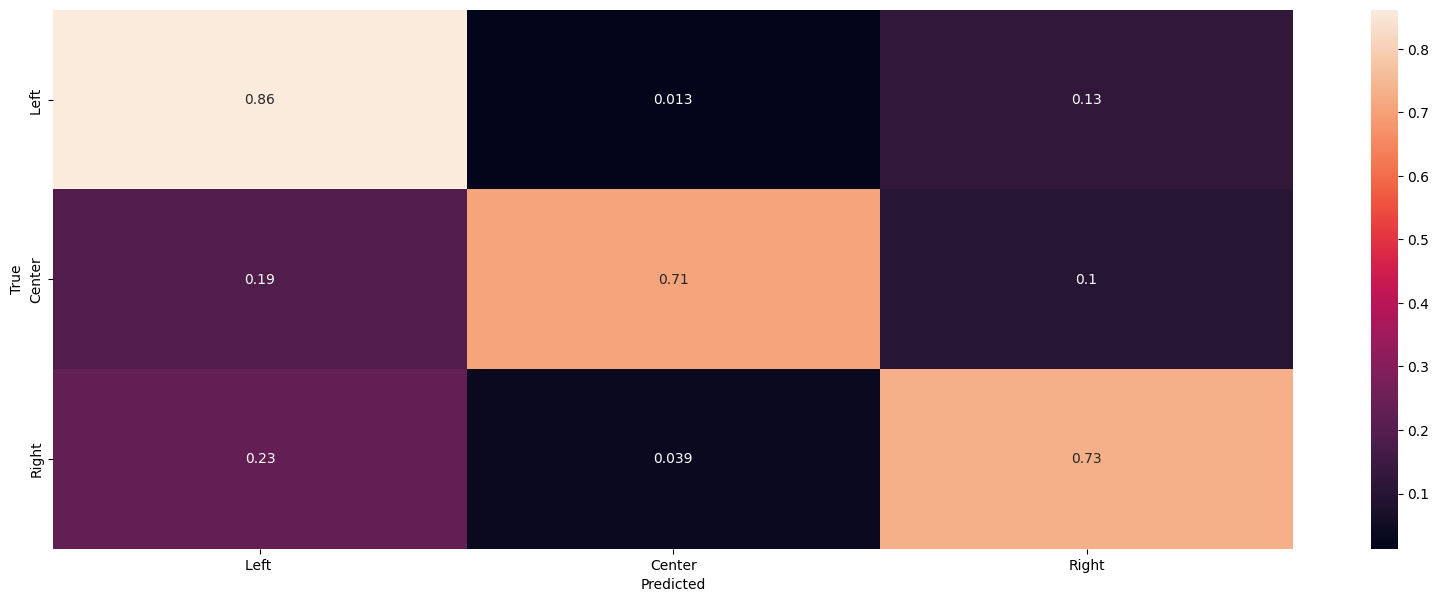

In [23]:
target_names=['Left ','Center','Right']
plot_confusion_matrix(y_test, predictions_model.numpy(), target_names)

In [24]:
bert_cls_wrong_guesses = np.where(y_test != predictions_model.numpy())

In [25]:
print(f'Number of Wrong Guesses: ',len(bert_cls_wrong_guesses[0]))

Number of Wrong Guesses:  969


In [26]:
#sampling 20 of the wrong precditions
wrong_guesses = [i for i in np.squeeze(bert_cls_wrong_guesses[0])]
decoded_wrong_guesses_text=[]

for i in wrong_guesses[:]:
  decoded_text = bert_tokenizer.decode(x_test['input_ids'][i], skip_special_tokens=True)

  # print("Input text:")
  # print(decoded_text)
  decoded_wrong_guesses_text.append(decoded_text)
  # print("True label:")
  # print(y_test.iloc[i])
  # print("Predicted label:")
  # print(predictions_model.numpy()[i])

  # print("-" * 50)



In [27]:
len(decoded_wrong_guesses_text)

969

In [28]:
# Get the actual indices of the rows with wrong guesses
wrong_guesses_indices = test_df.index[wrong_guesses]

# Now use these correct indices to extract the relevant rows
sources_analysis = test_df.loc[wrong_guesses_indices]

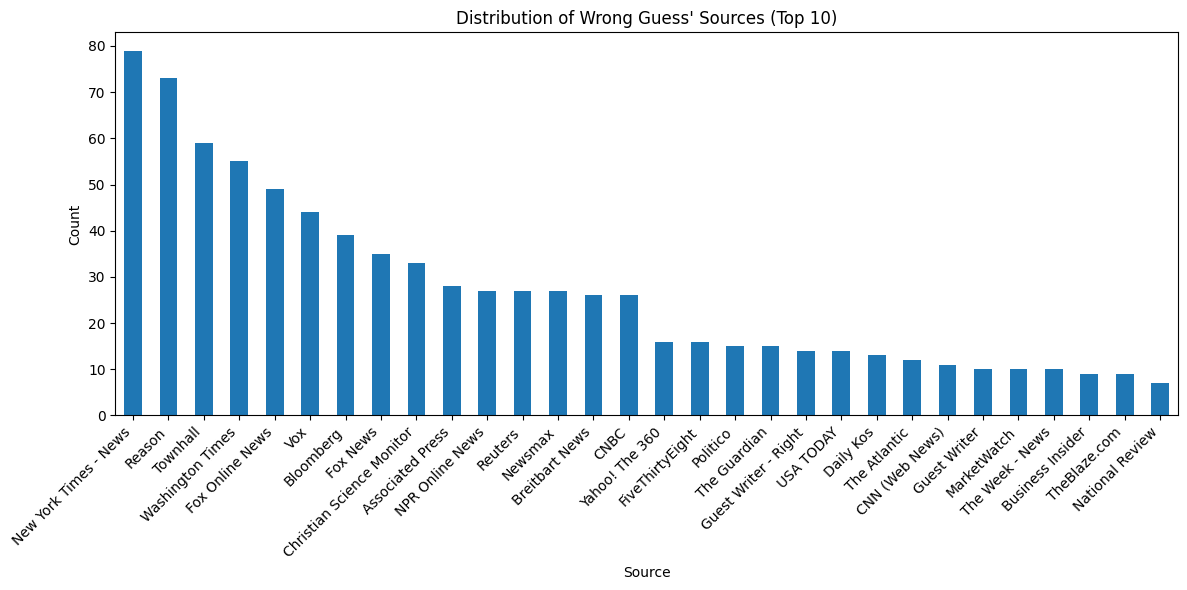

In [29]:
# Count the occurrences of each source
source_counts = sources_analysis['source'].value_counts()

# Get the top 10 sources
top_sources = source_counts.head(30)

# Create a bar plot for the top 10 sources
plt.figure(figsize=(12, 6))
top_sources.plot(kind='bar')

# Customize the plot
plt.title("Distribution of Wrong Guess' Sources (Top 10)")
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

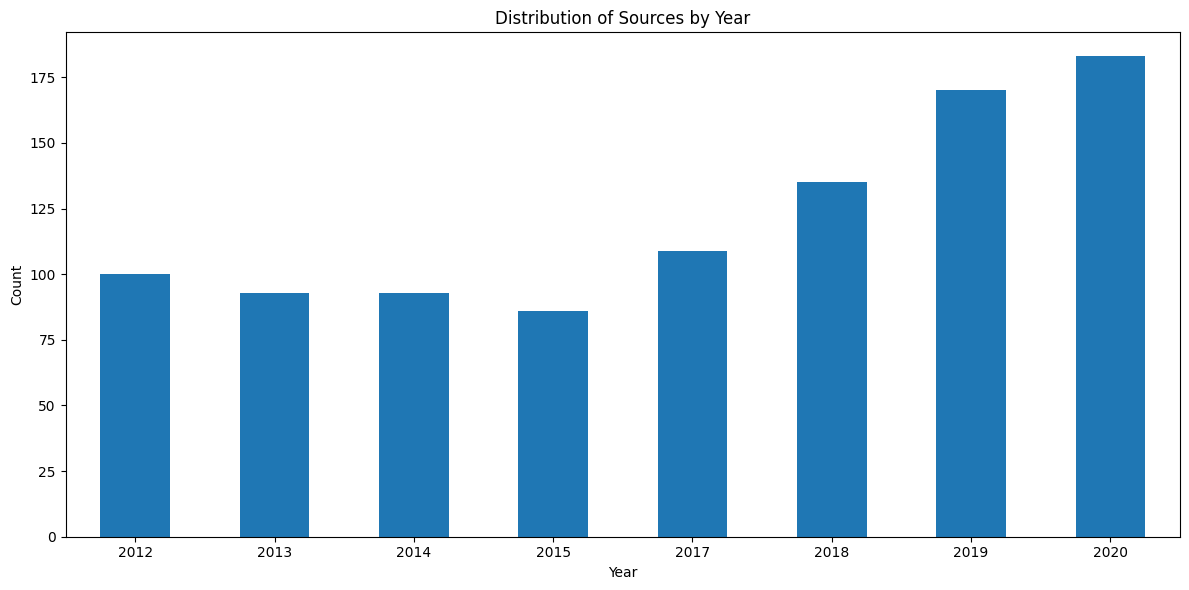

In [30]:
# Convert 'date' to datetime if it's not already
sources_analysis['date'] = pd.to_datetime(sources_analysis['date'])

# Extract year from the date
sources_analysis['year'] = sources_analysis['date'].dt.year

# Count occurrences of each year
year_counts = sources_analysis['year'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar')

# Customize the plot
plt.title('Distribution of Sources by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)  # No rotation for years
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# for i in wrong_guesses[:50]:
#   decoded_text = bert_tokenizer.decode(x_test['input_ids'][i], skip_special_tokens=True)

#   print("Input text:")
#   print(decoded_text)
#   print("True label:")
#   print(y_test.iloc[i])
#   print("Predicted label:")
#   print(predictions_model.numpy()[i])

#   print("-" * 50)


In [31]:
decoded_wrong_guesses_df = pd.DataFrame({'text': decoded_wrong_guesses_text})

# Now you can save it to a CSV file
decoded_wrong_guesses_df.to_csv('bert_cls_fine_tuning_wrong guess(7.24.24).csv', index=False)